In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import stockutils



from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import export_graphviz
from graphviz import Source


from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

#track experiments
import wandb
from wandb.integration.xgboost import WandbCallback

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "exploratory_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

#targetName = "TwoStDayAfterMajRev"
targetName = "TwoStateMajorReversals"

2024-07-25 15:02:28.237509: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 15:02:28.237572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 15:02:28.238527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 15:02:28.245620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 15:02:29.112587: W tensorflow/compiler/tf2

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
stockdf, targetdf, otherdf = stockutils.import_stock_csv("AAPL_Advanced.csv", target=targetName)
y_orig = targetdf["Target"]
print(y_orig.shape)
#targetdf.rename(columns={"DayAfterMajorReversal":'Target'}, inplace=True)
#targetdf.head()

(2371,)


# LSTM

Note that we do not have any offset data in the current dataset, so we can split cleanly, and won't get future information contaminating our current state.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(stockdf, y_orig, test_size=0.2,shuffle=False)

other_test = otherdf.iloc[-y_test.shape[0]:]

In [5]:
wandb.login(key="d2e07e8a9d7ef675859816d6e8230c50ccd2846d")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: candrews1971 (christopherandrews). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Base ROI

In [6]:
import math
bah_actuals = pd.DataFrame(data=y_test, columns=["Target"], index=y_test.index.copy())
bah_actuals['close'] = other_test['close']
max_ROI = stockutils.calculate_total_gains_bhs(bah_actuals, init_value=1000, init_price=bah_actuals['close'][0])

num_bought = math.floor(1000/ bah_actuals['close'][0])
bah_ROI = (bah_actuals['close'][-1] - bah_actuals['close'][0])
bah_ROI

Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 174.55, cash balance: $1137.7000000000003
Buying 8 shares for 138.34. Remaining Balance: 30.980000000000246
Selling all shares for 155.74, cash balance: $1276.9000000000003
Buying 9 shares for 134.87. Remaining Balance: 63.07000000000039
Selling all shares for 151.29, cash balance: $1424.6800000000003
Buying 11 shares for 125.02. Remaining Balance: 49.460000000000264
Selling all shares for 155.33, cash balance: $1758.0900000000004
Buying 12 shares for 145.31. Remaining Balance: 14.370000000000346
Selling all shares for 196.45, cash balance: $2371.77
Buying 13 shares for 174.00. Remaining Balance: 109.76999999999998
Selling all shares for 189.70, cash balance: $2575.87
Buying 15 shares for 171.21. Remaining Balance: 7.7199999999998
Selling all shares for 180.71, cash balance: $2718.37
Buying 16 shares for 166.89. Remaining Balance: 48.13000000000011
Selling all shares for 198.11, cash balance: $3217.

62.640000000000015

In [7]:
type(y_train)

pandas.core.series.Series

In [8]:
X_train.shape

(1896, 23)

# Inputs

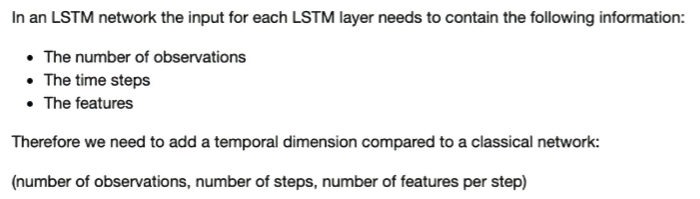

# Configuration

In [9]:
# first, set up our configuration (will be logged)
configs = dict(
    num_classes = 1,
    earlystopping_patience = 15,
    sequence_length = 5,
    epochs = 75,
    optimizer = 'nadam',
    learning_rate = 0.0005,
    targetName = targetName,
    batch_size = 16,
)

## Create Sequences

In [10]:
y_test_orig = y_test.copy()

# Convert y to numbers
y_train= pd.Categorical(y_train).codes
y_test= pd.Categorical(y_test).codes
y_orig= pd.Categorical(y_orig).codes

In [11]:
type(y_train)

numpy.ndarray

In [12]:
# First, we have to convert our dataframes to numpy arrays

X_train = X_train.values
#y_train = y_train.to_numpy() #conversion to categorical (above) does this for us

X_test = X_test.values
#y_test = y_test.to_numpy()

X_orig = stockdf.values
#y_orig = y_orig.to_numpy()

In [13]:
assert(len(X_orig) == len(X_train) + len(X_test))
len(X_orig)

2371

In [14]:
type(X_train)


numpy.ndarray

In [15]:
seq_length = configs['sequence_length']

Xtr = []
ytr = []
Xt = []
yt = []
Xo= []
yo = []
for i in range(seq_length, len(X_train)):
    Xtr.append(X_train[i -seq_length: i, :X_train.shape[1]])
    ytr.append(y_train[i])# starts appending at 0.  Can we use shift() instead? 
# do the same for Xt, yt
for i in range(seq_length, len(X_test)):
    Xt.append(X_test[i -seq_length: i, :X_test.shape[1]])
    yt.append(y_test[i])
for i in range(seq_length, len(X_orig)):
    Xo.append(X_orig[i -seq_length: i, :X_orig.shape[1]])
    yo.append(y_orig[i])

## First change - make tensors instead of np Arrays

In [16]:
# convert to np arrays again
# Xtr = np.array(Xtr)
# ytr = np.array(ytr)
# Xt = np.array(Xt)
# yt = np.array(yt)
# Xo = np.array(Xo)
# yo = np.array(yo)
Xtr = torch.tensor(Xtr).to(torch.float32)#.to(device)
ytr = torch.tensor(ytr).to(torch.float32)
Xt = torch.tensor(Xt).to(torch.float32)
yt = torch.tensor(yt).to(torch.float32)

/tmp/ipykernel_4181206/2969473904.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  Xtr = torch.tensor(Xtr).to(torch.float32)#.to(device)


In [17]:
Xtr.shape
print(f"Samples: {Xtr.shape[0]}, Timesteps: { Xtr.shape[1]},  Features: {Xtr.shape[2]}")

Samples: 1891, Timesteps: 5,  Features: 23


In [18]:
num_features = Xtr.shape[2]

In [19]:
class MyLSTM(nn.Module):
    def __init__(self):
        '''create and init weights and biases'''
        super().__init__()

        self.lstm = nn.LSTM(input_size=num_features, #number of features
                            hidden_size=50, # hidden size should equal the number of outputs you want, in case you are feeding it to another layer
                            num_layers=6, #number of stacked LSTM layers
                            dropout=0.2,# do we want a dropout layers in between LSTM layers? if so, probablility of dropout
                            batch_first=True) # use (batch, timestep, feature) notation instead of (seq, batch, feature)
        self.linear = nn.Linear(50,1) # 

    def forward(self, input):
        '''forward pass, through UNROLLED LSTM unit'''
       
        #view() transposes our input that is a single row, into a single column with 4 rows (i.e. the depth of the history we want)
        #input_trans = input.view(len(input), 1)
        #print("Input shape:", input.shape)
        # run the transposed vector thru the lstm layer
        lstm_out, temp = self.lstm(input)
        #lstm_out, temp = self.lstm(input_trans)
        lstm_out = self.linear(lstm_out)
        
        #print("Output of forward: ", lstm_out.shape)
        prediction = lstm_out[:, -1, :]  # this was key!
        #prediction = lstm_out[-1]
        return prediction

In [20]:
from torchinfo import summary
#create the model
model1 = MyLSTM().to(device)  # so that the parameters are on the GPU as well

summary(model1)

Layer (type:depth-idx)                   Param #
MyLSTM                                   --
├─LSTM: 1-1                              117,000
├─Linear: 1-2                            51
Total params: 117,051
Trainable params: 117,051
Non-trainable params: 0

In [21]:
from aiml_utils.mytorch import train_step, train
import torch.optim as optim
import torch.utils.data as data
import os

BATCH_SIZE = 16

#create dataloader(s)
train_dataloader = data.DataLoader(data.TensorDataset(Xtr, ytr), shuffle=False, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(data.TensorDataset(Xt, yt), shuffle=False, batch_size=BATCH_SIZE)

In [22]:
#create an optimizer
optimizer = optim.Adam(model1.parameters(), lr=0.001)

#create the loss function
#loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()

In [23]:
# use our train method
results = train(model1, 
      train_dataloader=train_dataloader, 
      test_dataloader=test_dataloader,
      optimizer=optimizer, 
      loss_fn=loss_fn,
      epochs = 100, 
      save_best=False, save_file="./pytorch_models/model1_best.pth")#, logToTensorboard=True )

  0%|          | 0/100 [00:00<?, ?it/s]

y_pred for your model torch.Size([16, 1]) is not the same shape as your 'y' data torch.Size([16])
y_pred for your model torch.Size([16, 1]) is not the same shape as your 'y' data torch.Size([16])
y_pred for your model torch.Size([16, 1]) is not the same shape as your 'y' data torch.Size([16])
y_pred for your model torch.Size([16, 1]) is not the same shape as your 'y' data torch.Size([16])
y_pred for your model torch.Size([16, 1]) is not the same shape as your 'y' data torch.Size([16])
y_pred for your model torch.Size([16, 1]) is not the same shape as your 'y' data torch.Size([16])
y_pred for your model torch.Size([16, 1]) is not the same shape as your 'y' data torch.Size([16])
y_pred for your model torch.Size([16, 1]) is not the same shape as your 'y' data torch.Size([16])
y_pred for your model torch.Size([16, 1]) is not the same shape as your 'y' data torch.Size([16])
y_pred for your model torch.Size([16, 1]) is not the same shape as your 'y' data torch.Size([16])
y_pred for your mode

In [50]:
model1.to(device) # make sure its on the GPU

model1.eval()

with torch.inference_mode():
    pred_logits = model1(Xt.to(device))
    

In [51]:
len(pred_logits)

470

In [52]:
pred_logits.shape

torch.Size([470, 1])

In [54]:
pred_logits[:10]

tensor([[-0.9416],
        [-0.6555],
        [-0.7914],
        [-0.5574],
        [-0.5733],
        [-0.8999],
        [-0.3725],
        [-0.5904],
        [-0.4364],
        [-0.9371]], device='cuda:0')

Need to convert to binary class

In [63]:
#torch.round(pred_logits)
testPred = torch.round(torch.sigmoid(pred_logits)).to('cpu')

In [60]:
y_test_orig = y_test_orig[configs['sequence_length']:]

In [62]:
lstm_preds = pd.DataFrame(data=testPred, columns=["Target"], index=y_test_orig.index.copy())
lstm_preds['close'] = other_test['close']
#run.summary["ROI"] = stockutils.calculate_total_gains_bs(lstm_preds, init_value=1000, init_price=lstm_preds['close'][0])
roi = stockutils.calculate_total_gains_bs(lstm_preds, init_value=1000, init_price=lstm_preds['close'][0])
print("ROI: ", roi)

Buying 6 shares for 160.01. Remaining Balance: 39.940000000000055
Selling all shares for 171.52, cash balance: $1069.0600000000002
Buying 7 shares for 146.10. Remaining Balance: 46.36000000000024
Selling all shares for 138.98, cash balance: $1019.2200000000001
Buying 7 shares for 138.38. Remaining Balance: 50.56000000000017
Selling all shares for 142.41, cash balance: $1047.4300000000003
Buying 7 shares for 143.75. Remaining Balance: 41.18000000000029
Selling all shares for 138.38, cash balance: $1009.8400000000003
Buying 6 shares for 149.70. Remaining Balance: 111.64000000000033
Selling all shares for 151.29, cash balance: $1019.3800000000003
Buying 6 shares for 148.11. Remaining Balance: 130.72000000000025
Selling all shares for 141.17, cash balance: $977.7400000000002
Buying 6 shares for 148.31. Remaining Balance: 87.88000000000022
Selling all shares for 140.94, cash balance: $933.5200000000002
Buying 6 shares for 143.21. Remaining Balance: 74.26000000000022
Selling all shares for 1

Still not very promising